In [ ]:
# Gene expression signature scoring based on updated DESeq2 analysis from Matthias

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os, gc, re, joblib
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize as cnorm
import anndata
import scanpy as sc
import sctk as sk
#import bbknn
import phate

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = sk.expression_colormap()

In [2]:
import seaborn as sn
import numpy_groupies as npg

import plotnine as pln
from plotnine import ggplot, aes

In [3]:
def load_de_genes(fn, sep=',', max_p=0.01, min_lfc=2, max_n=1000):
    de_df = pd.read_csv(fn, sep=sep, index_col=0)
    de_df = de_df.where(lambda x: (x.padj < max_p) & (x.log2FoldChange > np.log2(min_lfc))).dropna().sort_values(['padj', 'log2FoldChange'], ascending=[True, False])
    return de_df.iloc[0:max_n, :]

In [4]:
!ls bulkRNA_DE_v2/csv/*.csv

bulkRNA_DE_v2/csv/DESeq2_IFNA.csv   bulkRNA_DE_v2/csv/DESeq2_IL22.csv
bulkRNA_DE_v2/csv/DESeq2_IFNG.csv   bulkRNA_DE_v2/csv/DESeq2_IL6.csv
bulkRNA_DE_v2/csv/DESeq2_IL13.csv   bulkRNA_DE_v2/csv/DESeq2_OSM.csv
bulkRNA_DE_v2/csv/DESeq2_IL17A.csv  bulkRNA_DE_v2/csv/DESeq2_TGFB1.csv
bulkRNA_DE_v2/csv/DESeq2_IL1B.csv   bulkRNA_DE_v2/csv/DESeq2_TNF.csv


In [5]:
rna_stimulations = !ls bulkRNA_DE_v2/csv/ | cut -f2 -d '_'
rna_stimulations = [f.strip(".csv") for f in rna_stimulations]

In [6]:
rna_up_genes = {rstim: load_de_genes(f'bulkRNA_DE_v2/csv/DESeq2_{rstim}.csv', sep=',', max_p=0.05, min_lfc=1.5) for rstim in rna_stimulations}

In [7]:
np.log2(1.5)

0.5849625007211562

In [8]:
{k: len(v) for k,v in rna_up_genes.items()}

{'IFNA': 448,
 'IFNG': 535,
 'IL13': 127,
 'IL17A': 65,
 'IL1B': 290,
 'IL22': 53,
 'IL6': 1,
 'OSM': 157,
 'TGFB1': 268,
 'TNF': 456}

In [9]:
#rna_ad = sc.read('scRNA_batch1_2.processed.h5ad')
rna_ad = sc.read('../data/rna/scRNA_batch1_2.processed.fibroblasts.h5ad')

Only considering the two last: ['.fibroblasts', '.h5ad'].
Only considering the two last: ['.fibroblasts', '.h5ad'].


In [10]:
rna_ad = anndata.AnnData(rna_ad.raw.X, obs=rna_ad.obs.copy(), var=rna_ad.raw.var.copy(), obsm=rna_ad.obsm.copy())

In [11]:
rna_ad

AnnData object with n_obs × n_vars = 26727 × 17592
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc'
    obsm: 'X_pca', 'X_umap', 'X_umap_bk'

# Process

## RNA gene scoring

In [12]:
rna_ad

AnnData object with n_obs × n_vars = 26727 × 17592
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc'
    obsm: 'X_pca', 'X_umap', 'X_umap_bk'

In [13]:
for rstim, rup in rna_up_genes.items():
    g = rup.index.to_list()
    sc.tl.score_genes(rna_ad, g, ctrl_size=len(g), score_name=f'{rstim}_upreg')

In [14]:
for rstim in rna_up_genes.keys():
    x = rna_ad.obs[f'{rstim}_upreg'].values
    rna_ad.obs[f'{rstim}_upreg_scaled'] = (x-x.mean()) / np.std(x)

In [15]:
#sk.plot_embedding(rna_ad, groupby='annot1', basis='umap_bk');

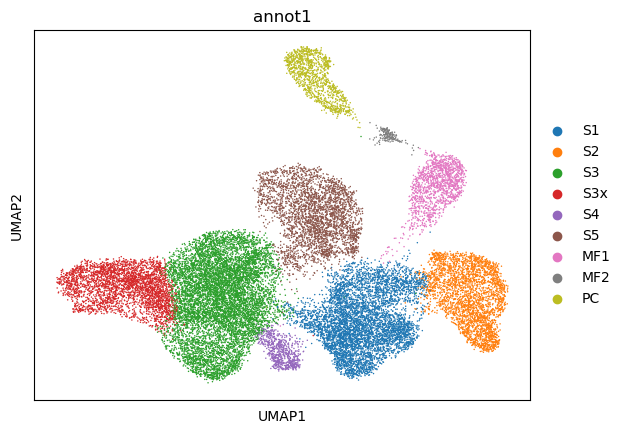

In [16]:
sc.pl.umap(rna_ad, color='annot1')

In [18]:
# rna_up_genes_show = rna_up_genes.copy()
# del rna_up_genes_show['IL6']
# #del rna_up_genes_show['IL22']

# sc.set_figure_params(dpi_save=300)

# sk.set_figsize((3, 3))
# sc.pl.embedding(
#     rna_ad,
#     basis='X_umap',
#     color=['annot1'] + [f'{rstim}_upreg' for rstim in rna_up_genes_show.keys()],
#     ncols=5,
#     #cmap='viridis',
#     cmap='RdBu_r',
#     title=['Cell type'] + [f'{rstim}_upreg, n={rna_up_genes[rstim].shape[0]}' for rstim in rna_up_genes_show.keys()],
#     #vmin=-0.5, vmax=1,
#     #vcenter=0,
#     #save="_bulkDE_signature_projection_scaled.pdf"
# )

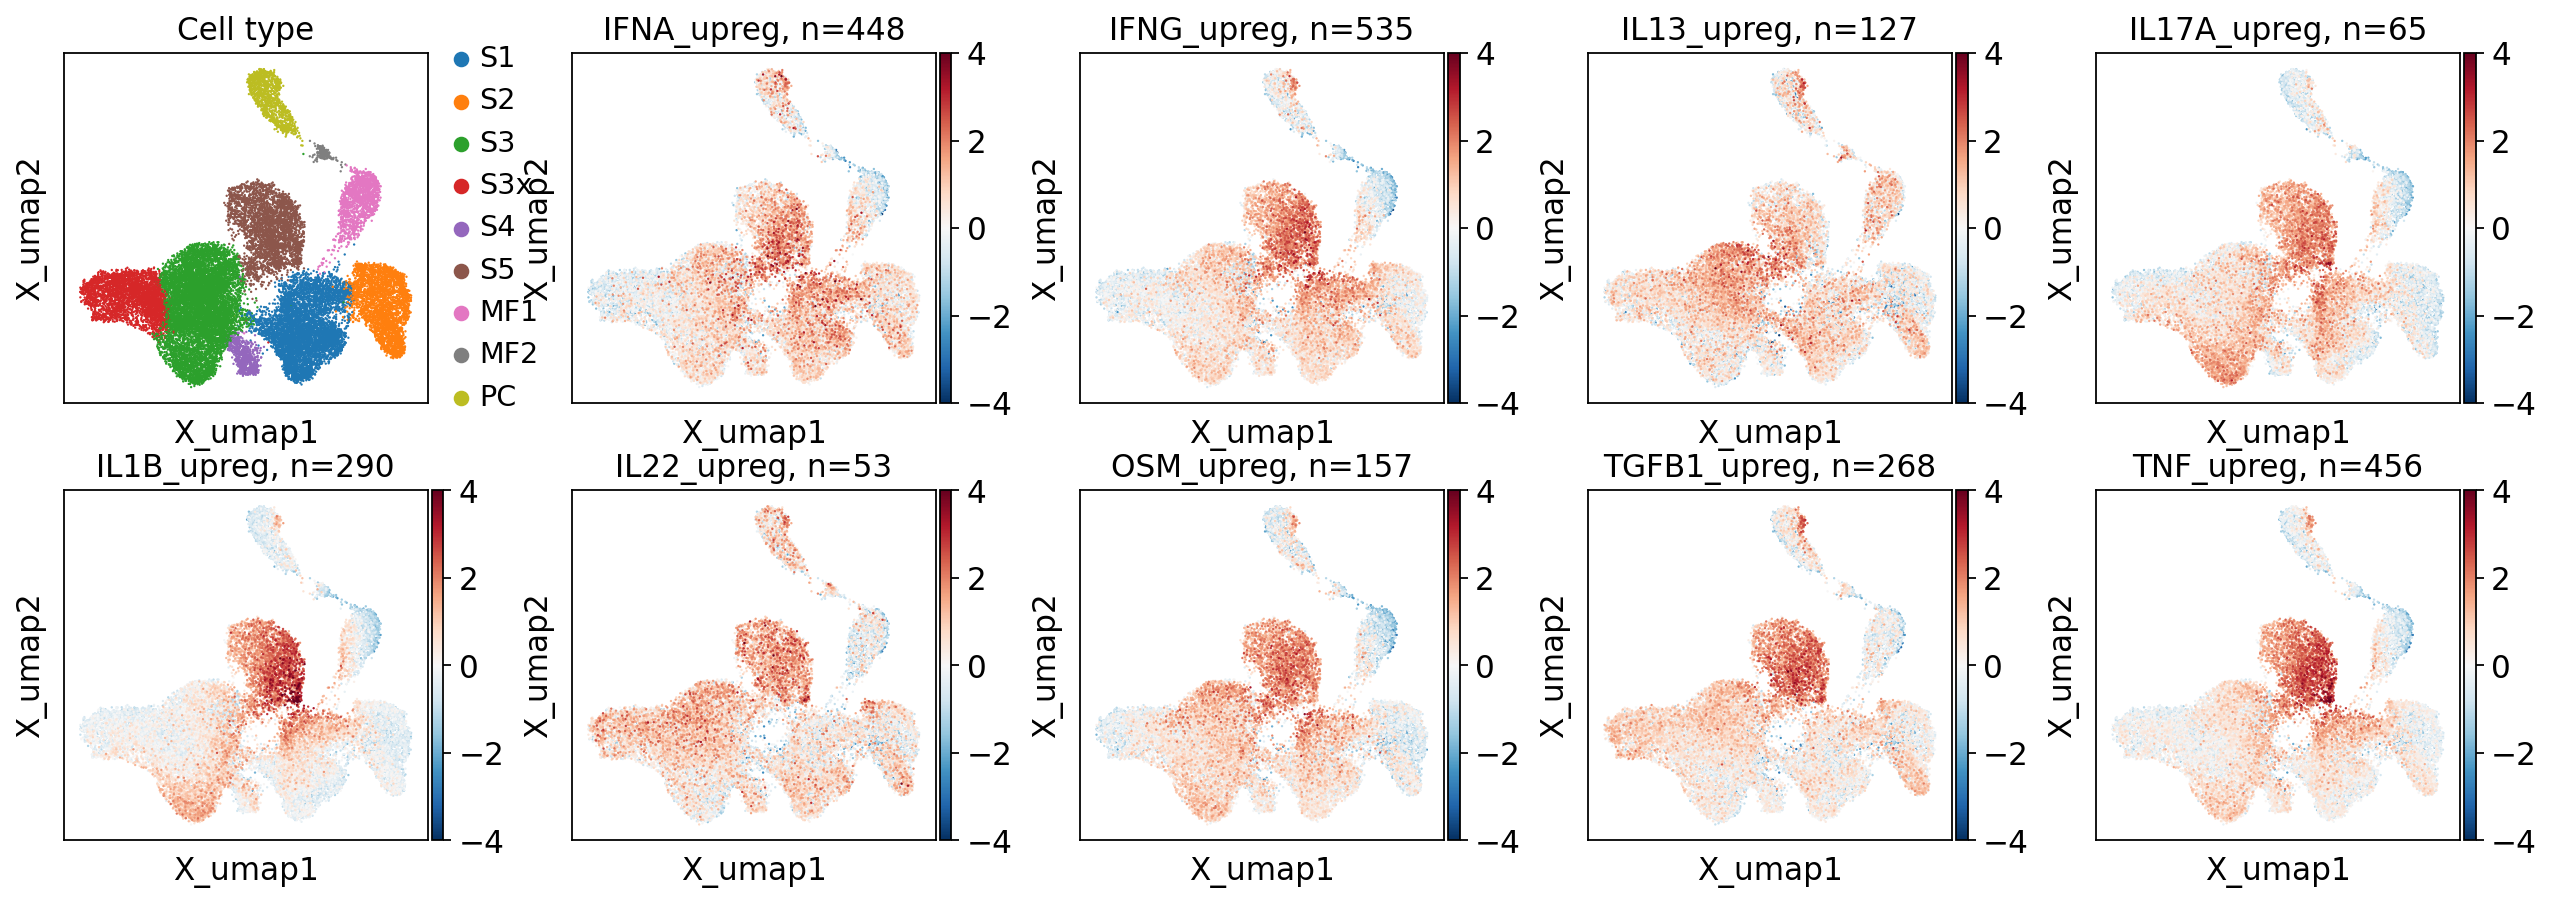

In [19]:
rna_up_genes_show = rna_up_genes.copy()
del rna_up_genes_show['IL6']
#del rna_up_genes_show['IL22']

sc.set_figure_params(dpi_save=300)

sk.set_figsize((3, 3))
sc.pl.embedding(
    rna_ad,
    basis='X_umap',
    color=['annot1'] + [f'{rstim}_upreg_scaled' for rstim in rna_up_genes_show.keys()],
    ncols=5,
    #cmap='viridis',
    cmap='RdBu_r',
    title=['Cell type'] + [f'{rstim}_upreg, n={rna_up_genes[rstim].shape[0]}' for rstim in rna_up_genes_show.keys()],
    vmin=-4, vmax=4,
    #vcenter=0,
    save="_bulkDE_signature_projection_scaled_v3.pdf"
)

In [21]:
import seaborn as sns

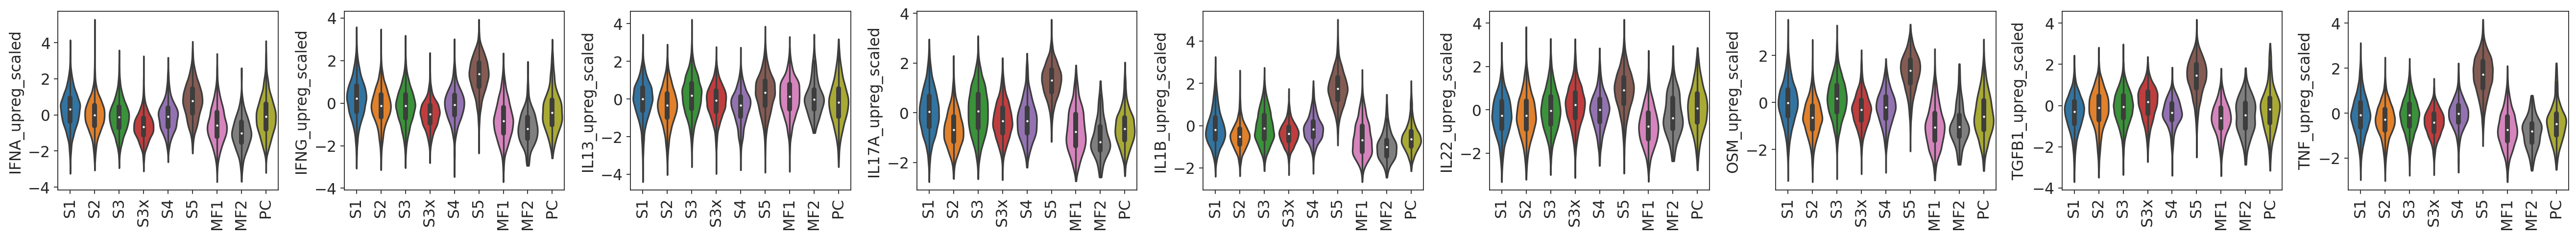

In [22]:
sk.set_figsize((4, 3))

sns.set_style("ticks")  # to prevent gridlines
sc.pl.violin(
    rna_ad,
    groupby='annot1',
    #keys=[f'{rstim}_upreg' for rstim in rna_up_genes.keys() if rstim not in ('IL6')],
    keys=[f'{rstim}_upreg_scaled' for rstim in rna_up_genes.keys() if rstim not in ('IL6')],

    #jitter=False,
    stripplot=False,
    inner='box',
    #figsize=(20, 4),
    rotation=90,
    save="_bulkDE_signature_projection_v4.pdf",
    grid=False
)


In [21]:
# save bulkRNA DE scoring
rna_ad.obs[[f'{rstim}_upreg' for rstim in rna_up_genes.keys()]].to_csv('scRNA_batch1_2.v2.bulkDE_scoring.csv.gz')

In [22]:
rna_upreg_df = pd.DataFrame(
    npg.aggregate(rna_ad.obs.annot1.cat.codes, rna_ad.obs[[f'{rstim}_upreg_scaled' for rstim in rna_up_genes.keys()]].values, func='mean', axis=0),
    index=rna_ad.obs.annot1.cat.categories, columns=list(rna_up_genes.keys())
)

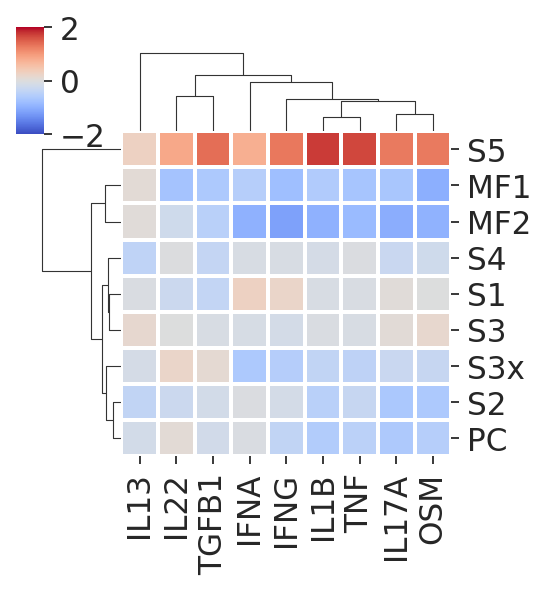

In [24]:
cg = sn.clustermap(
    #rna_upreg_df[[stim for stim in rna_upreg_df.columns if stim not in ('IL6', 'IL22')]],
    rna_upreg_df[[stim for stim in rna_upreg_df.columns if stim not in ('IL6')]],

    cmap='coolwarm',
    figsize=(3.5, 3.7),
    linewidths=1,  # separating lines
    vmin=-2,
    vmax=2);
# cg.ax_row_dendrogram.set_visible(False);
# cg.ax_col_dendrogram.set_visible(False);
#cg.fig.suptitle('Up-regulated genes')
cg.savefig("figures/heatmap_bulkDE_signature_projection_scaled_v3.pdf")
plt.show()

In [44]:
# sk.set_figsize((6, 3))
# for rstim in rna_up_genes.keys():
#     sc.pl.violin(rna_ad, [f'{rstim}_upreg'], groupby='annot1', stripplot=False, rotation=90)